## Capstone Project - Bundestag Data Set

Parliamentary debates protocols from 1949-2021

**Political Argument Assistant**

Business Goal: "what arguments where put forward in favor and against the EURO"?
   
Evaluation Metric: Accuracy?




### Questions

- data cleaning: 
    - Role vs pos_speechbeginning
    - check for other values surrounding \* # remove or ignore \n, \t and words such as 'Euro-\npa' in column 'text'?
    - Löbe/ Labe: parsing errors
    - drop col Unnamed: 0
    
    
- EDA:
    
- vector embedding: FAISS

### 1. Init

In [1]:
# data handling & viz
import pandas as pd
import matplotlib.pyplot as plt

# language-related packages
import re #regex
from wordcloud import WordCloud
import spacy # DE stopwords

# other
import warnings
warnings.filterwarnings('ignore')


In [2]:
df_raw_debates = pd.read_csv("data/all_bundestag_speeches_replication_data.csv")

In [3]:
df_raw_debates.shape

(877140, 13)

In [4]:
df_raw_debates.columns.to_list()

['Unnamed: 0',
 'doc_id',
 'doc_lp_id',
 'speech_identification_ent',
 'date',
 'period',
 'session',
 'pos_speechbeginning',
 'Party',
 'Role',
 'governing_Party',
 'text',
 'text_length']

In [5]:
df_raw_debates.head()

,Unnamed: 0,doc_id,doc_lp_id,speech_identification_ent,date,period,session,pos_speechbeginning,Party,Role,governing_Party,text,text_length
0,0,0,0,Alterspräsident Labe:,07.09.1949,1,1,\nAlterspräsident Labe:,no-text,Alterspraesident,no-text,Meine Damen und Herren! Abgeordnete des Deuts...,1670
1,1,1,1,Dr. Adenauer (CDU):,07.09.1949,1,1,\nDr. Adenauer (CDU):,CDU/CSU,MdB,1.0,Namens der Fraktion der CDU/CSU schlage ich a...,15
2,2,2,2,Alterspräsident Löbe:,07.09.1949,1,1,\nAlterspräsident Löbe:,no-text,Alterspraesident,no-text,Das Wort hat der Herr Abgeordnete Reimann.\n,7
3,3,3,3,Reimann (KPD):,07.09.1949,1,1,\nReimann (KPD):,KPD,MdB,0.0,Ich schlage im Namen der kommunistischen Frak...,22
4,4,4,4,Alterspräsident Löbe:,07.09.1949,1,1,\nAlterspräsident Löbe:,no-text,Alterspraesident,no-text,Sie haben die Vorschläge gehört: Hans Böhm un...,57


In [6]:
df_raw_debates.describe()

,Unnamed: 0,doc_id,doc_lp_id,period,session,text_length
count,877140.000000,877140.000000,877140.000000,877140.000000,877140.000000,877140.000000
mean,438569.500000,438569.500000,25356.538075,10.675568,120.529621,245.665244
std,253208.651896,253208.651896,16277.215712,4.956654,68.088480,629.664638
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,219284.750000,219284.750000,11541.000000,7.000000,63.000000,10.000000
50%,438569.500000,438569.500000,23320.000000,11.000000,119.000000,43.000000
75%,657854.250000,657854.250000,38221.000000,15.000000,175.000000,193.000000
max,877139.000000,877139.000000,63829.000000,19.000000,282.000000,47655.000000


In [7]:
df_raw_debates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877140 entries, 0 to 877139
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Unnamed: 0                 877140 non-null  int64 
 1   doc_id                     877140 non-null  int64 
 2   doc_lp_id                  877140 non-null  int64 
 3   speech_identification_ent  877140 non-null  object
 4   date                       877140 non-null  object
 5   period                     877140 non-null  int64 
 6   session                    877140 non-null  int64 
 7   pos_speechbeginning        877140 non-null  object
 8   Party                      877140 non-null  object
 9   Role                       877140 non-null  object
 10  governing_Party            875074 non-null  object
 11  text                       875086 non-null  object
 12  text_length                877140 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 87.0+ M

### 2. Data Cleaning

In [8]:
# set datetime
df_raw_debates['date'] = pd.to_datetime(df_raw_debates['date'], format='%d.%m.%Y')


In [9]:
# drop colun 'Unnamed: 0'
df_raw_debates = df_raw_debates.drop(columns=['Unnamed: 0'])

In [10]:
# allocate governing_Party = 0 where Party == 'fraktionslos' (i.e. independent MP)
df_raw_debates.loc[df_raw_debates['Party'] == 'fraktionslos', 'governing_Party'] = 0

# allocate governing_Party = 0 where Party == 'parteilos' 
df_raw_debates.loc[df_raw_debates['Party'] == 'parteilos', 'governing_Party'] = 0

# allocate governing_Party = 0 where Party == 'DRP' 
df_raw_debates.loc[df_raw_debates['Party'] == 'DRP', 'governing_Party'] = 0

# allocate governing_Party = 0 where Party == 'DPB' 
df_raw_debates.loc[df_raw_debates['Party'] == 'DPB', 'governing_Party'] = 0

In [11]:
# allocate governing_Party = 0 where '0.0' or '0'
df_raw_debates.loc[df_raw_debates['governing_Party'].isin(['0.0', '0']), 'governing_Party'] = 0

# allocate governing_Party = 1 where '1.0' or '1'
df_raw_debates.loc[df_raw_debates['governing_Party'].isin(['1.0', '1']), 'governing_Party'] = 1

In [12]:
# check values for governing_Party
df_raw_debates['governing_Party'].unique()

array(['no-text', 1, 0], dtype=object)

In [13]:
# check where no gov party indicated
df_na_party = df_raw_debates[df_raw_debates['governing_Party'].isna()].copy()
df_na_party.shape


(0, 12)

In [14]:
# show where no text indicated (empty cell)
df_na_text = df_raw_debates[df_raw_debates['text'].isna()].copy()
df_na_text.shape

(2054, 12)

In [15]:
# drop where no text indicated (empty cell)
df_raw_debates = df_raw_debates.dropna(subset=['text']).copy()

In [16]:
# show where text_length is 0
df_zero_text = df_raw_debates[df_raw_debates['text_length'] == 0].copy()
df_zero_text.shape

(260, 12)

In [17]:
# drop rows where text_length is 0 
df_raw_debates = df_raw_debates[df_raw_debates['text_length'] != 0].copy()


In [18]:
df_raw_debates.head()

,doc_id,doc_lp_id,speech_identification_ent,date,period,session,pos_speechbeginning,Party,Role,governing_Party,text,text_length
0,0,0,Alterspräsident Labe:,1949-09-07,1,1,\nAlterspräsident Labe:,no-text,Alterspraesident,no-text,Meine Damen und Herren! Abgeordnete des Deuts...,1670
1,1,1,Dr. Adenauer (CDU):,1949-09-07,1,1,\nDr. Adenauer (CDU):,CDU/CSU,MdB,1,Namens der Fraktion der CDU/CSU schlage ich a...,15
2,2,2,Alterspräsident Löbe:,1949-09-07,1,1,\nAlterspräsident Löbe:,no-text,Alterspraesident,no-text,Das Wort hat der Herr Abgeordnete Reimann.\n,7
3,3,3,Reimann (KPD):,1949-09-07,1,1,\nReimann (KPD):,KPD,MdB,0,Ich schlage im Namen der kommunistischen Frak...,22
4,4,4,Alterspräsident Löbe:,1949-09-07,1,1,\nAlterspräsident Löbe:,no-text,Alterspraesident,no-text,Sie haben die Vorschläge gehört: Hans Böhm un...,57


In [19]:
# below 1-5: example cleaning for \n
# 1️⃣ Filter for the specific row by id
example_row = df_raw_debates[df_raw_debates['doc_id'] == 744292].copy()
example_row

,doc_id,doc_lp_id,speech_identification_ent,date,period,session,pos_speechbeginning,Party,Role,governing_Party,text,text_length
744292,744292,10050,Präsident Dr. Norbert Lammert:,2010-06-10,17,46,\nGesetzentwurfs.\n\n\nPräsident Dr. Norbert L...,no-text,Bundestagspraesident,no-text,\nDas Wort erhält nun der Kollege Manfred Zöll...,11


In [20]:
# 2️⃣ Show original text
print("Original text:")
print(repr(example_row['text'].values[0]))

Original text:
'\nDas Wort erhält nun der Kollege Manfred Zöllmer für\n\ndie SPD-Fraktion.\n\n\n'


In [21]:
# 3️⃣ Replace all newline characters (\n) with a space
example_row['text_cleaned'] = example_row['text'].str.replace(r'\n+', ' ', regex=True)


In [22]:
# 4️⃣ Strip leading/trailing spaces and collapse multiple spaces
example_row['text_cleaned'] = example_row['text_cleaned'].str.strip().str.replace(r'\s+', ' ', regex=True)


In [23]:
# 5️⃣ Show cleaned text
print("\nCleaned text:")
print(repr(example_row['text_cleaned'].values[0]))


Cleaned text:
'Das Wort erhält nun der Kollege Manfred Zöllmer für die SPD-Fraktion.'


In [24]:
# check for cells containing \t (tab)
df_tab_debates = df_raw_debates[df_raw_debates['text'].str.contains('r\t', na=False)].copy()
df_tab_debates.shape

(477, 12)

In [25]:
# check for cell containing '\n', '\n\n' or '\n\n\n'
# values can be '\nSehr verehrte ....', 'Sehr verehrte...\n', 'Sehr \nverehrte ...', '\nSehr \nverehrte ...\n'
df_typo_debates = df_raw_debates[df_raw_debates['text'].str.contains('r\n', na=False)].copy()
df_typo_debates.shape


(158136, 12)

In [26]:
# rows where a word is split across a newline with a hyphen
hyphen_linebreaks = df_raw_debates[df_raw_debates['text'].str.contains(r'\w-\n\w', regex=True, na=False)].copy()

# num of rows
print(f"Rows with hyphen-line breaks: {len(hyphen_linebreaks)}")

Rows with hyphen-line breaks: 186059


In [27]:
# TODO check for other values surrounding \*
# remove or ignore \n, \t and words such as 'Euro-\npa' in column 'text'?


In [28]:
df_raw_debates.shape

(874826, 12)

In [29]:
# all unique roles
raw_roles = df_raw_debates['Role'].unique()
raw_roles

array(['Alterspraesident', 'MdB', 'Bundestagspraesident',
       'Schriftfuehrer', 'Bundeskanzler', 'Bundesminister',
       'Vizepraesident', 'Staatssekretär', 'Staatsminister',
       'Landesminister', 'Senator', 'Buergermeister', 'Gastredner',
       'Wehrbeauftragter', 'Beauftragter'], dtype=object)

In [30]:
# all unique parties
party = df_raw_debates['Party'].unique()
party

array(['no-text', 'CDU/CSU', 'KPD', 'SPD', 'FDP', 'BP', 'Cabinet', 'DP',
       'Zentrum', 'NR', 'WAV', 'parteilos', 'NS', 'DRP', 'SRP', 'GB/BHE',
       'fraktionslos', 'FU', 'DPB', 'DA', 'GRÜNE', 'PDS', 'LINKE', 'AfD'],
      dtype=object)

In [31]:
df_gastredner = df_raw_debates[df_raw_debates['Role'] == 'Gastredner']
df_gastredner

,doc_id,doc_lp_id,speech_identification_ent,date,period,session,pos_speechbeginning,Party,Role,governing_Party,text,text_length
24588,24588,93,"Mr. Joseph W. Martin, Speaker des. Repräsentan...",1953-10-29,2,5,"\nIch bitte ihn, das Wort zu nehmen.\nMr. Jose...",no-text,Gastredner,no-text,"\nEs ist eine große Ehre für mich, vor dieser ...",1228


In [32]:
# irrelevant roles to be dropped, effectively keep same as LNKTW24
irr_roles = ['Gastredner', 'Landesminister', 'Bundestagspraesident', 'Vizepraesident', 'Alterspraesident', 'Senator', 'Buergermeister', 'Wehrbeauftragter', 'Beauftragter', 'Schriftfuehrer']

# LNKTW2024 keep only ['MdB','Bundeskanzler','Bundesminister','Staatssekretär', 'Staatsminister']
roles = ['MdB','Bundeskanzler','Bundesminister','Staatssekretär', 'Staatsminister']

# all roles
all_roles = roles + irr_roles

In [33]:
# irrelevant speeches (procedural, guest speakers, non-members of Parliament)
irr_debates = df_raw_debates[df_raw_debates['Role'].isin(irr_roles)].copy()
irr_debates.shape

(353697, 12)

In [34]:
# cleaned dataframe for further processing
df_debates = df_raw_debates[df_raw_debates['Role'].isin(roles)].copy()
df_debates.shape

(521129, 12)

In [35]:
irr_debates.nunique()

doc_id                       353697
doc_lp_id                     61994
speech_identification_ent      1358
date                           4092
period                           19
session                         282
pos_speechbeginning           67381
Party                             1
Role                             10
governing_Party                   2
text                         255050
text_length                    3349
dtype: int64

In [36]:
df_debates.nunique()

doc_id                       521129
doc_lp_id                     63078
speech_identification_ent     15448
date                           4280
period                           19
session                         282
pos_speechbeginning           91951
Party                            23
Role                              5
governing_Party                   2
text                         502907
text_length                    5427
dtype: int64

In [37]:
df_debates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521129 entries, 1 to 877139
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   doc_id                     521129 non-null  int64         
 1   doc_lp_id                  521129 non-null  int64         
 2   speech_identification_ent  521129 non-null  object        
 3   date                       521129 non-null  datetime64[ns]
 4   period                     521129 non-null  int64         
 5   session                    521129 non-null  int64         
 6   pos_speechbeginning        521129 non-null  object        
 7   Party                      521129 non-null  object        
 8   Role                       521129 non-null  object        
 9   governing_Party            521129 non-null  object        
 10  text                       521129 non-null  object        
 11  text_length                521129 non-null  int64        

In [38]:
# unique parties
df_debates['Party'].unique()

# fraktionslos =/= parteilos

array(['CDU/CSU', 'KPD', 'SPD', 'FDP', 'BP', 'Cabinet', 'DP', 'Zentrum',
       'NR', 'WAV', 'parteilos', 'NS', 'DRP', 'SRP', 'GB/BHE',
       'fraktionslos', 'FU', 'DPB', 'DA', 'GRÜNE', 'PDS', 'LINKE', 'AfD'],
      dtype=object)

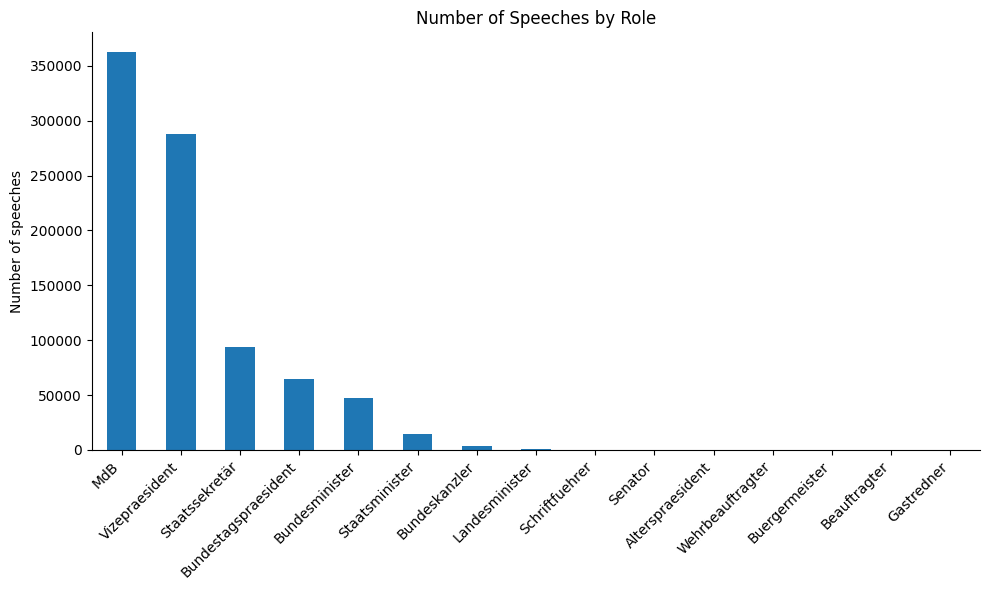

In [39]:
# Filter to only the roles of interest
#df_filtered = df_raw_debates[df_raw_debates['Role'].isin(all_roles)].copy()

# Count total number of speeches per role
role_counts = df_raw_debates['Role'].value_counts().reindex(all_roles).sort_values(ascending=False) 

# Plot
plt.figure(figsize=(10,6))
ax = role_counts.plot(kind='bar', color='C0') 

# save ink
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Number of speeches')
plt.xlabel('')
plt.title('Number of Speeches by Role')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/all_speeches_by_role.png')
plt.show()

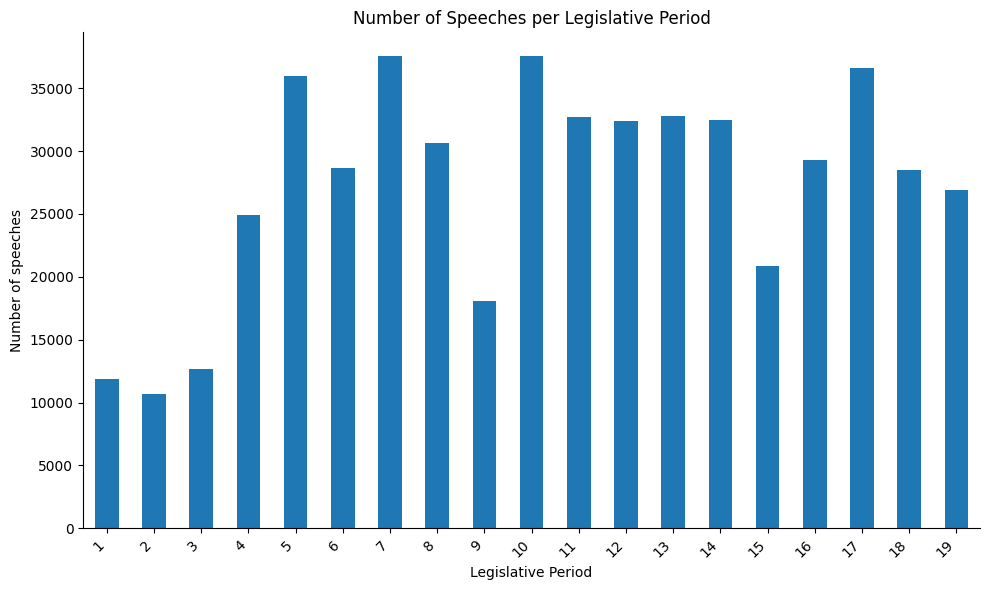

In [40]:
# Count speeches per period
speeches_per_period = df_debates.groupby('period')['doc_id'].count().sort_index()

# Plot
plt.figure(figsize=(10,6))
ax = speeches_per_period.plot(kind='bar', color='C0')

# Remove top/right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Number of speeches')
plt.xlabel('Legislative Period')
plt.title('Number of Speeches per Legislative Period')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

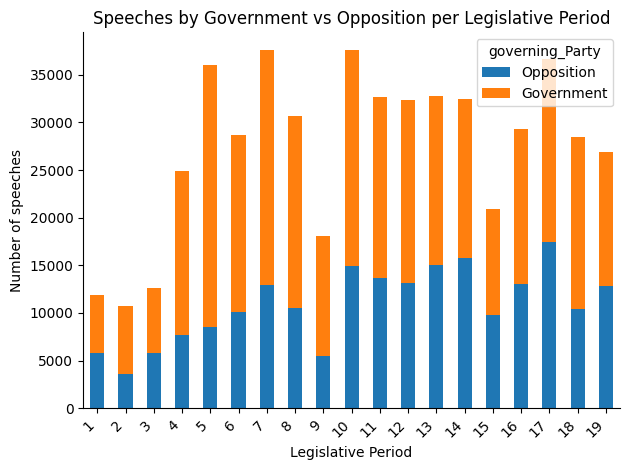

In [41]:
# todo: move legend outside of bar plot
# speeches by period and gov status
stacked_counts = (
    df_debates
    .groupby(['period', 'governing_Party'])['doc_id']
    .count()
    .unstack(fill_value=0)
    .sort_index()
)

# rename columns
stacked_counts = stacked_counts.rename(
    columns={0: 'Opposition', 1: 'Government'}
)

# plot
plt.figure(figsize=(10,6))
ax = stacked_counts.plot(kind='bar', stacked=True)

# save-ink 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Number of speeches')
plt.xlabel('Legislative Period')
plt.title('Speeches by Government vs Opposition per Legislative Period')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/speeches_over_lps.png')
plt.show()

In [42]:
# parties per period
df_debates.groupby('period')['Party'].nunique()

period
1     18
2      8
3      6
4      4
5      4
6      5
7      5
8      5
9      5
10     6
11     7
12     7
13     7
14     7
15     6
16     7
17     7
18     6
19     8
Name: Party, dtype: int64

In [43]:
# government parties per period
df_debates[df_debates['governing_Party']==1].groupby('period')['Party'].unique()

period
1             [CDU/CSU, FDP, Cabinet, DP]
2     [CDU/CSU, FDP, Cabinet, GB/BHE, DP]
3                  [CDU/CSU, Cabinet, DP]
4                 [CDU/CSU, FDP, Cabinet]
5            [CDU/CSU, Cabinet, FDP, SPD]
6                     [SPD, Cabinet, FDP]
7                     [SPD, FDP, Cabinet]
8                     [SPD, FDP, Cabinet]
9            [SPD, FDP, Cabinet, CDU/CSU]
10                [CDU/CSU, FDP, Cabinet]
11                [CDU/CSU, FDP, Cabinet]
12                [CDU/CSU, FDP, Cabinet]
13                [CDU/CSU, FDP, Cabinet]
14                  [SPD, GRÜNE, Cabinet]
15                  [SPD, GRÜNE, Cabinet]
16                [CDU/CSU, SPD, Cabinet]
17                [CDU/CSU, FDP, Cabinet]
18                [CDU/CSU, SPD, Cabinet]
19                [SPD, CDU/CSU, Cabinet]
Name: Party, dtype: object

In [44]:
# cabinet = government members
df_cabinet = df_debates[df_debates['Party']=='Cabinet'].copy()
df_cabinet.shape

(158839, 12)

In [45]:
pd.DataFrame(df_debates.text_length).describe(percentiles=[0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 0.995])

,text_length
count,521129.000000
mean,361.203596
std,668.466412
min,1.000000
5%,6.000000
10%,16.000000
15%,23.000000
25%,37.000000
50%,95.000000
75%,531.000000


<Figure size 1200x500 with 0 Axes>

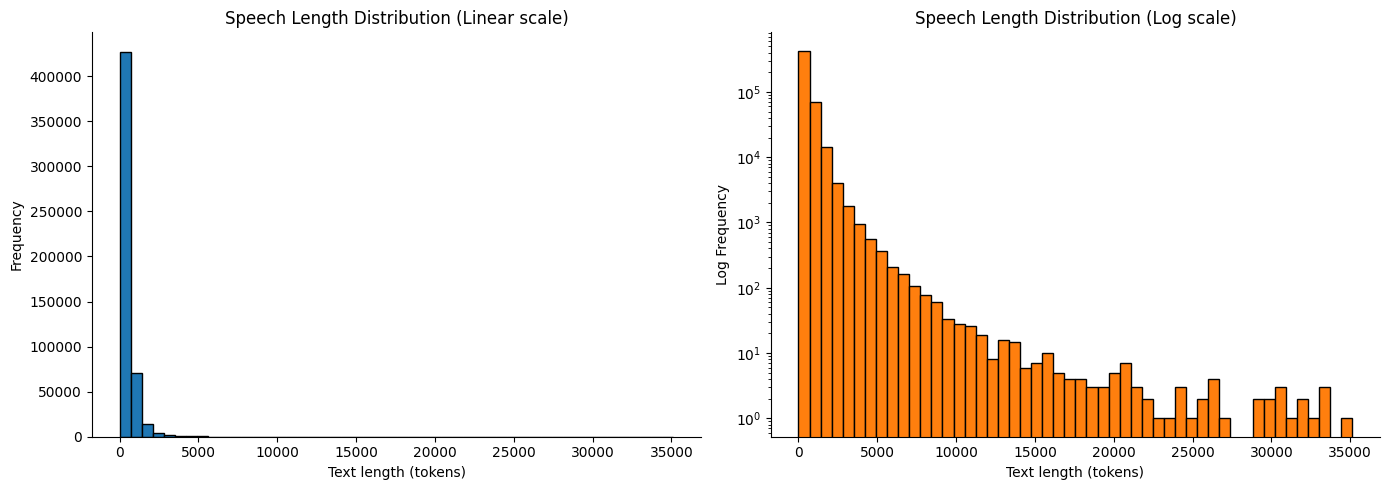

In [46]:
# todo: add plot with logged values on x-axis only
# plot distribution of text_length

plt.figure(figsize=(12,5))

# two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# linear scale histogram
axes[0].hist(df_debates['text_length'], bins=50, color='C0', edgecolor='black')
axes[0].set_xlabel('Text length (tokens)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Speech Length Distribution (Linear scale)')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# logarithmic scale histogram
axes[1].hist(df_debates['text_length'], bins=50, color='C1', edgecolor='black', log=True)
axes[1].set_xlabel('Text length (tokens)')
axes[1].set_ylabel('Log Frequency')
axes[1].set_title('Speech Length Distribution (Log scale)')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('images/speech_length_distribution.png')
plt.show()

In [47]:
# show long debates (what is long?)
df_long_debates = df_debates[df_debates['text_length']>= 20000]
df_long_debates.shape

(42, 12)

In [48]:
# aggregate all text per legislative period
period_text = df_debates.groupby('period')['text'].apply(lambda x: ' '.join(x)).to_dict()

In [49]:
# stopwords from spacy package: total 543

nlp = spacy.load("de_core_news_sm")
german_stopwords = nlp.Defaults.stop_words

#print(sorted(list(german_stopwords))[:])

In [50]:
# custom stopwords for WordCloud
custom_stopwords = german_stopwords.union({'Herr', 'Frau', 'Präsident', 'Präsidentin', 'Bundestag', 'Bundesrat', 'Deutschland', 'Meine', 'Damen', 'Herren', 'Bundesregierung', 'Bundeskanzler', 'Bundeskanzlerin', 'Kanzler', 'Kanzlerin', 'Bundesrepublik', 
                                         'Staatssekretär', 'Staatssekretärin', 'Staatsminister', 'Staatsministerin', 'Bundesminister', 'Bundesministerin', 'Minister', 'Ministerin', 'Meine', 'verehrten',
                                           'Frage', 'Fragen', 'glaube', 'sagen', 'Gesetze', 'Gesetzes', 'Antrag', 'Gesetzentwurf', 'Politik', 'Prozent', 'Kollege', 'Kollegin', 'Kollegen', 'Kolleginnen', 'deutschen', 'deutsche', 'Deutschen', 'deutsch', 'deutschem', 'Regierung',
                                           'eigentlich', 'genau', 'lassen', 'Zusammenhang', 'Länder', 'Ländern', 'Opposition', 'brauchen', 'Thema', 'Auffassung', 'Meinung', 'Gebiet', 'Ausschuß', 'Ausschuss', 'bitte', 'geben', 'stellen', 'steht', 'sehen', 'insbesondere', 
                                           'nämlich', 'Seite', 'Bund', 'Wort', 'Fall', 'Fälle', 'Rahmen', 'einfach', 'geehrte', 'Reden', 'mal', 'Hause', 'wissen', 'geehrter', 'geehrte', 'Herrn', 'gegeben', 'Parlament',
                                           'gilt', 'sage', 'denke', 'liegt', 'gehört', 'gehören', 'weiß', 'sicher', 'letzten', 'letzte', 'letzter', 'letztes', 'Wahlperiode', 'Sitzung',
                                           'deutlich', 'Bereich', 'Lage', 'Art', 'Z B', 'zb', 'z.B.', 'z b', 'z B', 'z B ', ' z B', 'z  B', 'stehen', 'klar', 'finde', 'Punkt', 'Rede', 'einzelnen', 'bereit', 'gesprochen', 'sprechen', 'einzelnen',
                                           'handelt', 'Weise', 'halten', 'Abs', 'übrigen', 'notwendig', 'selbstverständlich', 'getan', 'übrigen', 'j', 'ge', 'ha ben', 'nehmen'
                                        })

In [51]:
# reduced df size for experimental purposes: legislative period 19 (2017-2021)
df_2k_debates = df_debates[df_debates['period']>18] #26902 rows
df_2k_debates.shape

(26902, 12)

In [52]:
# Save experimentation df to CSV
df_2k_debates.to_csv('data/debates_2017_2021.csv', index=False)

In [56]:
# small sample df
# later: maybe remove very short text rows before to get larger samples
df_sample_debates = df_debates.sample(n=5_000, random_state=42)
df_sample_debates.shape

(5000, 12)

In [57]:
# save small exp df to CSV
df_sample_debates.to_csv('data/debates_sample_5k.csv', index=False)

KeyboardInterrupt: 

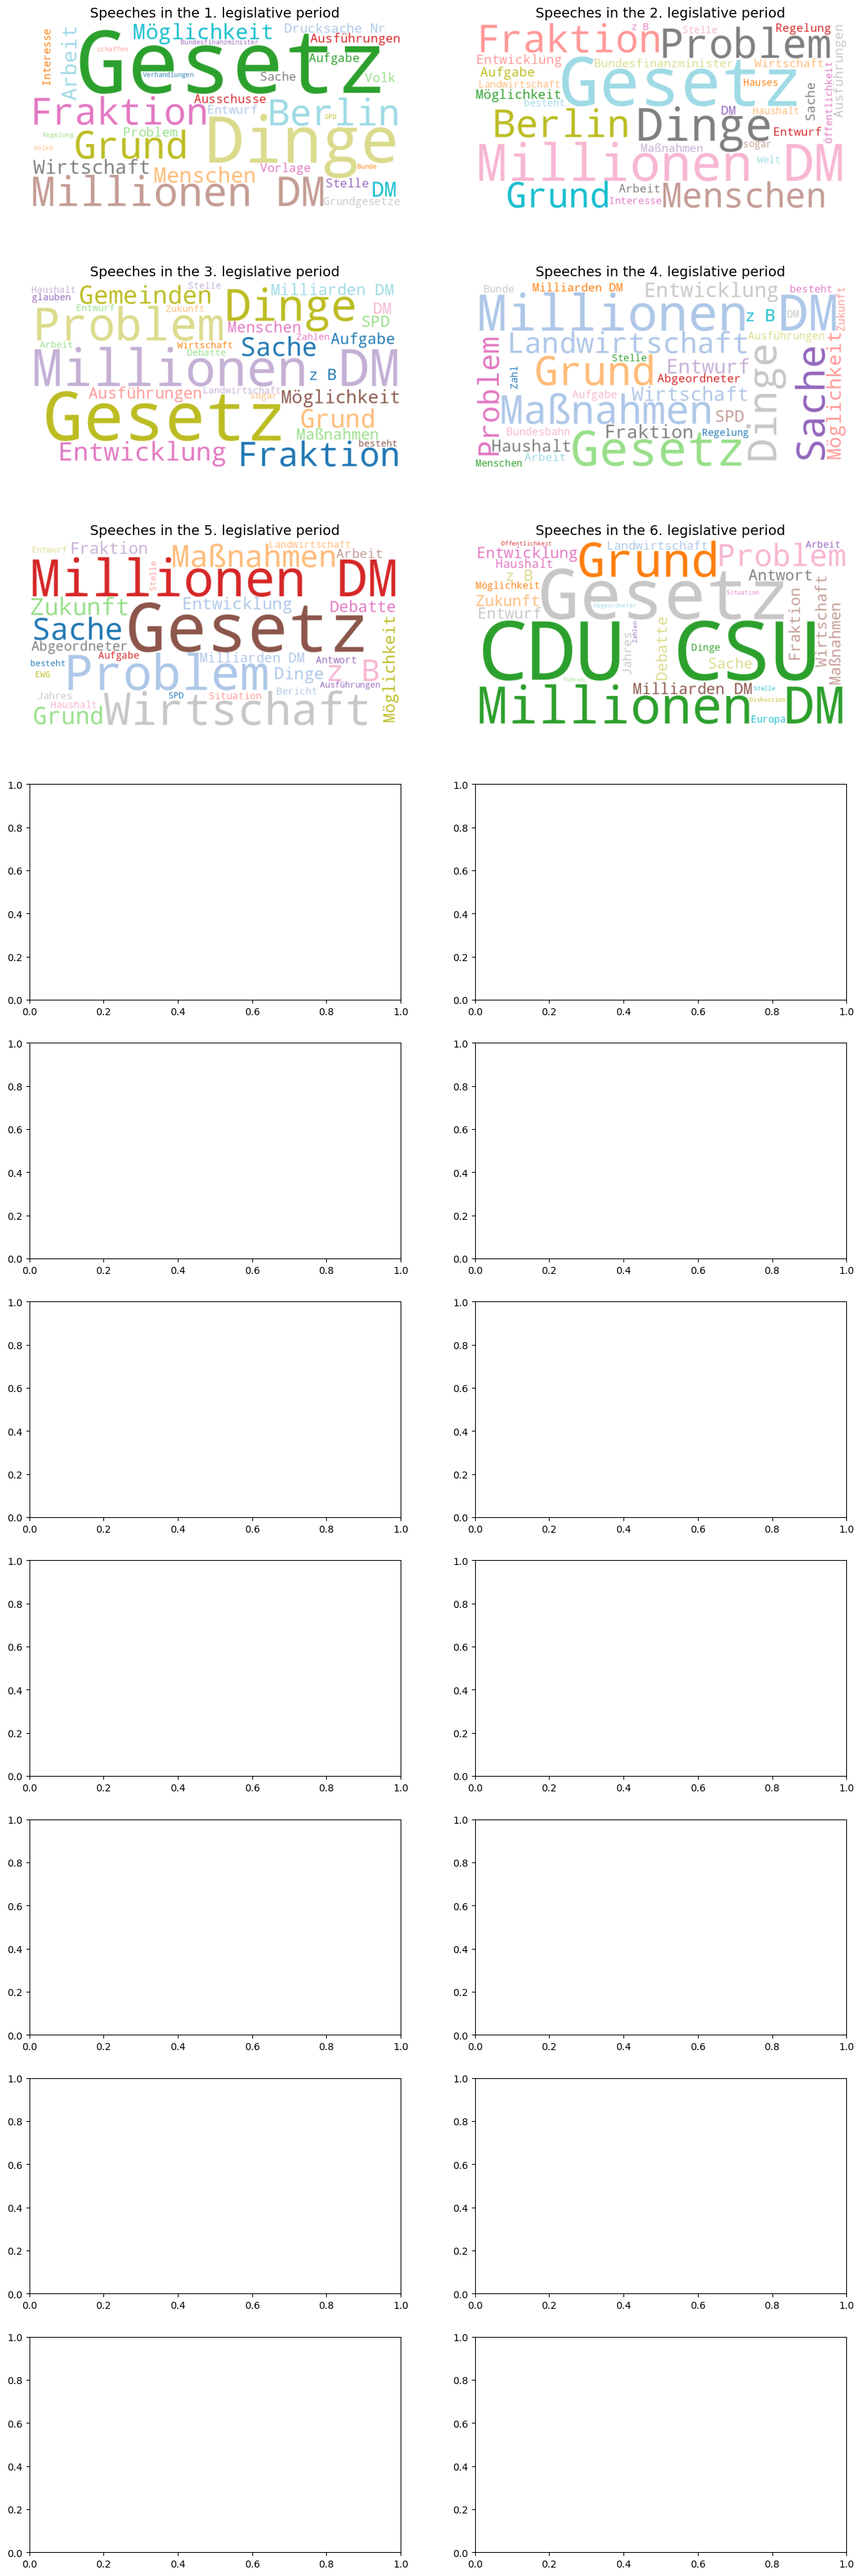

In [54]:
# word cloud per legislative period

# Create one word cloud per legislative period
fig, axes = plt.subplots(nrows=len(period_text)//2 + len(period_text)%2, ncols=2, figsize=(15, 5*len(period_text)//2))

axes = axes.flatten()  # flatten in case of single column

for i, (period, text) in enumerate(sorted(period_text.items())):
    wc = WordCloud(
        stopwords=custom_stopwords,
        width=800, 
        height=400,
        background_color='white',
        max_words=30,
        colormap='tab20'
    ).generate(text)
    wc.to_file(f"images/wordcloud_{period}.png")

    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Speeches in the {period}. legislative period', fontsize=14)

# remove any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()